In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils import data

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing,
                                              EqOddsPostprocessing,
                                              RejectOptionClassification)
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
random_state = 1

mps


pip install 'aif360[AdversarialDebiasing]'


In [2]:
# read in data and split
X = torch.load('inputs/rfw_senet50_face_embeddings.pt').cpu()
y = torch.load('inputs/rfw_senet50_labels.pt').cpu()
df = pd.read_csv('inputs/rfw_senet50_df.csv')
df['reference_ethnicity'] = df['reference_ethnicity'].str.lower()
ethnicity = df['reference_ethnicity']
df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,labels
0,m.0c7mh2,m.0c7mh2,african,African,1.0
1,m.0c7mh2,m.0c7mh2,african,African,1.0
2,m.026tq86,m.026tq86,african,African,1.0
3,m.026tq86,m.026tq86,african,African,1.0
4,m.02wz3nc,m.02wz3nc,african,African,1.0
...,...,...,...,...,...
29311,m.0402tg,m.01npnk3,caucasian,Caucasian,0.0
29312,m.05pbbnj,m.02rrb2n,caucasian,Caucasian,0.0
29313,m.09j6df,m.07kcsqd,african,African,0.0
29314,m.0fhrbz,m.025zgjt,african,African,0.0


In [3]:
train_split, test_split = train_test_split(np.arange(len(X)),test_size=0.2, random_state=random_state)
train_split, val_split = train_test_split(train_split,test_size=0.25, random_state=random_state)
X_train = X[train_split]
X_val = X[val_split]
X_test = X[test_split]
y_train = y[train_split]
y_val = y[val_split]
y_test = y[test_split]

ethnicity_train = ethnicity[train_split].values
ethnicity_train[ethnicity_train=='caucasian'] = 0
ethnicity_train[ethnicity_train=='african'] = 1
ethnicity_train = ethnicity_train.astype(int)

ethnicity_val = ethnicity[val_split].values
ethnicity_val[ethnicity_val=='caucasian'] = 0
ethnicity_val[ethnicity_val=='african'] = 1
ethnicity_val = ethnicity_val.astype(int)

ethnicity_test = ethnicity[test_split].values
ethnicity_test[ethnicity_test=='caucasian'] = 0
ethnicity_test[ethnicity_test=='african'] = 1
ethnicity_test = ethnicity_test.astype(int)

In [4]:
train_df = df.iloc[train_split]
val_df = df.iloc[val_split]
test_df = df.iloc[test_split]
val_df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,labels
14342,m.026j908,m.026j908,caucasian,Caucasian,1.0
253,m.0q3yxb2,m.0q3yxb2,african,African,1.0
19218,m.0bct0h,m.03qg12,caucasian,Caucasian,0.0
16461,m.08xxx9,m.0cz95jf,african,African,0.0
16869,m.0d88dr,m.05zcmc,african,African,0.0
...,...,...,...,...,...
11980,m.03vq05,m.03vq05,caucasian,Caucasian,1.0
12825,m.0gcr4zx,m.0gcr4zx,caucasian,Caucasian,1.0
21881,m.0b_c03,m.0278nmt,caucasian,Caucasian,0.0
1396,m.01t4wm,m.01t4wm,african,African,1.0


In [5]:
## train data
class TrainData(data.Dataset):
    
    def __init__(self, X_data, y_data,ethnicity):
        self.X_data = X_data
        self.y_data = y_data
        self.ethnicity = ethnicity    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.ethnicity[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train),
                       ethnicity_train)
test_data = TrainData(torch.FloatTensor(X_test),torch.FloatTensor(y_test),ethnicity_test)
val_data = TrainData(torch.FloatTensor(X_val), 
                       torch.FloatTensor(y_val),
                       ethnicity_val)
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 4096
        self.layer_1 = nn.Linear(4096, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

def confusion_mat(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = (tn + tp)/(tn+tp+fn+fp)
    return tn, fp, fn, tp, acc
    
def AOE(tn_1,fp_1,fn_1,tp_1,tn_0,fp_0,fn_0,tp_0):
    tpr_1 = tp_1/(tp_1+fn_1)
    tpr_0 = tp_0/(tp_0+fn_0)

    fpr_1 = fp_1/(fp_1+tn_1)
    fpr_0 = fp_0/(fp_0+tn_0)


    return (np.abs(fpr_1-fpr_0) + np.abs(tpr_1 - tpr_0))/2


In [6]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
print(device)
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_data, batch_size=143)
val_loader = data.DataLoader(dataset=val_data, batch_size=143)

mps


In [7]:
# training 
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
beta = 0.
for e in tqdm_notebook(range(0, EPOCHS),total=EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_tp = 0
    epoch_tn = 0
    epoch_fp = 0
    epoch_fn = 0

    for X_batch, y_batch,ethnicity_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        pred = torch.round(torch.sigmoid(y_pred)).detach().cpu().numpy()

        tn, fp, fn, tp, acc = confusion_mat(pred, y_batch.unsqueeze(1).cpu().numpy())

        caucasian_pred = pred[ethnicity_batch==0]
        african_pred = pred[ethnicity_batch==1]

        caucasian_label = y_batch.unsqueeze(1).cpu().numpy()[ethnicity_batch==0]
        african_label = y_batch.unsqueeze(1).cpu().numpy()[ethnicity_batch==1]

        caucasian_tn, caucasian_fp, caucasian_fn, caucasian_tp, caucasian_acc = confusion_mat(caucasian_pred, caucasian_label)
        african_tn, african_fp, african_fn, african_tp, african_acc = confusion_mat(african_pred, african_label)

        caucasian_fnr = caucasian_fn/(caucasian_fn+caucasian_tp)
        caucasian_fpr = caucasian_fp/(caucasian_fp+caucasian_tn)

        african_fnr = african_fn/(african_fn+african_tp)
        african_fpr = african_fp/(african_fp+african_tn)

    
        loss = criterion(y_pred,y_batch.unsqueeze(1)) #+ beta*(np.abs(african_fpr-caucasian_fpr) + np.abs(african_fnr-caucasian_fnr))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_tn += tn
        epoch_fp += fp
        epoch_fn += fn
        epoch_tp += tp

    # validation
    model.eval()
    val_loss = 0.0
    val_accs = 0
    with torch.no_grad():
        for X_val, y_val, ethnicity_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            val_out = model(X_val)
            val_pred = torch.round(torch.sigmoid(val_out)).detach().cpu().numpy()
            val_tn, val_fp, val_fn, val_tp, val_acc = confusion_mat(val_pred, y_val.unsqueeze(1).cpu().numpy())

            val_caucasian_pred = val_pred[ethnicity_val==0]
            val_african_pred = val_pred[ethnicity_val==1]

            val_caucasian_label = y_val.unsqueeze(1).cpu().numpy()[ethnicity_val==0]
            val_african_label = y_val.unsqueeze(1).cpu().numpy()[ethnicity_val==1]

            val_caucasian_tn, val_caucasian_fp, val_caucasian_fn, val_caucasian_tp, val_caucasian_acc = confusion_mat(val_caucasian_pred, val_caucasian_label)
            val_african_tn, val_african_fp, val_african_fn, val_african_tp, val_african_acc = confusion_mat(val_african_pred, val_african_label)

            val_caucasian_fnr = val_caucasian_fn/(val_caucasian_fn+val_caucasian_tp)
            val_caucasian_fpr = val_caucasian_fp/(val_caucasian_fp+val_caucasian_tn)

            val_african_fnr = val_african_fn/(val_african_fn+val_african_tp)
            val_african_fpr = val_african_fp/(val_african_fp+val_african_tn)
            
            vloss = criterion(val_out, y_val.unsqueeze(1)) + np.abs(val_african_fpr-val_caucasian_fpr) + np.abs(val_african_fnr-val_caucasian_fnr)
            val_loss+=vloss.item()
            val_accs+=val_acc
    train_losses.append(epoch_loss/len(train_loader))
    train_accuracies.append(epoch_acc/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    val_accuracies.append(val_accs/len(val_loader))

    if (e+1) % 5 ==0 :
        print(f'Epoch {e+1}: | Loss: {epoch_loss/len(train_loader):.7f} | Acc: {epoch_acc/len(train_loader):.7f}')
        print(f'TNR: {epoch_tn/(epoch_tn+epoch_fp):.7f} | TPR: {epoch_tp/(epoch_tp+epoch_fn):.7f} ')
        print(f'FNR: {epoch_fn/(epoch_fn+epoch_tp):.7f} | FPR: {epoch_fp/(epoch_fp+epoch_tn):.7f} ')
        
        print(f'Epoch {e+1}: | Val Loss: {val_loss/len(val_loader):.7f} | Val Acc: {val_accs/len(val_loader):.7f}')
        print(f'Val TNR: {val_tn/(val_tn+val_fp):.7f} | Val TPR: {val_tp/(val_tp+val_fn):.7f} ')
        print(f'Val FNR: {val_fn/(val_fn+val_tp):.7f} | Val FPR: {val_fp/(val_fp+val_tn):.7f} ')
    
        

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: | Loss: 0.1551231 | Acc: 0.9746237
TNR: 0.9595174 | TPR: 0.9900241 
FNR: 0.0099759 | FPR: 0.0404826 
Epoch 5: | Val Loss: 0.3170031 | Val Acc: 0.9273410
Val TNR: 0.9166667 | Val TPR: 0.9397590 
Val FNR: 0.0602410 | Val FPR: 0.0833333 
Epoch 10: | Loss: 0.0350033 | Acc: 0.9989205
TNR: 0.9984213 | TPR: 0.9994267 
FNR: 0.0005733 | FPR: 0.0015787 
Epoch 10: | Val Loss: 0.2506208 | Val Acc: 0.9343340
Val TNR: 0.9333333 | Val TPR: 0.9397590 
Val FNR: 0.0602410 | Val FPR: 0.0666667 
Epoch 15: | Loss: 0.0105153 | Acc: 0.9999432
TNR: 0.9998872 | TPR: 1.0000000 
FNR: 0.0000000 | FPR: 0.0001128 
Epoch 15: | Val Loss: 0.2501365 | Val Acc: 0.9367218
Val TNR: 0.9500000 | Val TPR: 0.9638554 
Val FNR: 0.0361446 | Val FPR: 0.0500000 
Epoch 20: | Loss: 0.0036103 | Acc: 1.0000000
TNR: 1.0000000 | TPR: 1.0000000 
FNR: 0.0000000 | FPR: 0.0000000 
Epoch 20: | Val Loss: 0.2328810 | Val Acc: 0.9420092
Val TNR: 0.9833333 | Val TPR: 0.9277108 
Val FNR: 0.0722892 | Val FPR: 0.0166667 


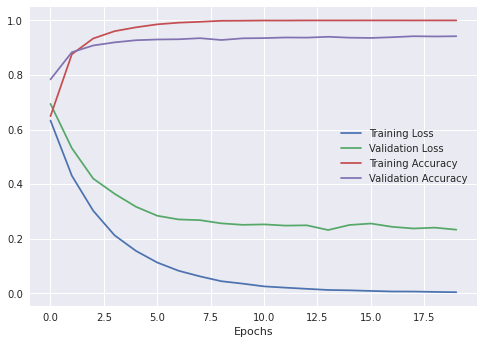

In [8]:
with plt.style.context('seaborn'):    
    plt.plot(train_losses,label='Training Loss')
    plt.plot(val_losses,label='Validation Loss')
    plt.plot(train_accuracies,label='Training Accuracy')
    plt.plot(val_accuracies,label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plt.show()

In [9]:
# testing validation bias
model.eval()
val_predictions = []
with torch.no_grad():
    for X_val, y_val,_ in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_out = model(X_val)
        val_pred = torch.round(torch.sigmoid(val_out)).detach().cpu().numpy().flatten()
        val_predictions.append(val_pred)

In [10]:
val_predictions[0].shape

(143,)

In [11]:
val_predictions = np.array(val_predictions).flatten()
val_df['predictions'] = val_predictions
val_df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,labels,predictions
14342,m.026j908,m.026j908,caucasian,Caucasian,1.0,1.0
253,m.0q3yxb2,m.0q3yxb2,african,African,1.0,1.0
19218,m.0bct0h,m.03qg12,caucasian,Caucasian,0.0,0.0
16461,m.08xxx9,m.0cz95jf,african,African,0.0,0.0
16869,m.0d88dr,m.05zcmc,african,African,0.0,0.0
...,...,...,...,...,...,...
11980,m.03vq05,m.03vq05,caucasian,Caucasian,1.0,1.0
12825,m.0gcr4zx,m.0gcr4zx,caucasian,Caucasian,1.0,1.0
21881,m.0b_c03,m.0278nmt,caucasian,Caucasian,0.0,0.0
1396,m.01t4wm,m.01t4wm,african,African,1.0,1.0


In [12]:
caucasian_val_df = val_df[val_df['reference_ethnicity']=='caucasian']
african_val_df = val_df[val_df['reference_ethnicity']=='african']

In [13]:

caucasian_val_preds = caucasian_val_df.predictions
african_val_preds = african_val_df.predictions

caucasian_val_labels = caucasian_val_df.labels
african_val_labels = african_val_df.labels


caucasian_tn, caucasian_fp, caucasian_fn, caucasian_tp, caucasian_acc = confusion_mat(caucasian_val_preds,caucasian_val_labels)
african_tn, african_fp, african_fn, african_tp, african_acc = confusion_mat(african_val_preds,african_val_labels)


caucasian_tnr = caucasian_tn/(caucasian_tn+caucasian_fp)
caucasian_tpr = caucasian_tp/(caucasian_tp+caucasian_fn)
caucasian_fnr = caucasian_fn/(caucasian_fn+caucasian_tp)
caucasian_fpr = caucasian_fp/(caucasian_fp+caucasian_tn)
caucasian_balanced_accuracy = (caucasian_tpr + caucasian_tnr)/2

african_tnr = african_tn/(african_tn+african_fp)
african_tpr = african_tp/(african_tp+african_fn)
african_fnr = african_fn/(african_fn+african_tp)
african_fpr = african_fp/(african_fp+african_tn)
african_balanced_accuracy = (african_tpr + african_tnr)/2

print(f'caucasian TNR: {caucasian_tn/(caucasian_tn+caucasian_fp):.3f} | caucasian TPR: {caucasian_tp/(caucasian_tp+caucasian_fn):.3f} ')
print(f'caucasian FNR: {caucasian_fn/(caucasian_fn+caucasian_tp):.3f} | caucasian FPR: {caucasian_fp/(caucasian_fp+caucasian_tn):.3f} ')
print(f'caucasian ACC: {caucasian_acc:.3f} | caucasian balanced ACC: {caucasian_balanced_accuracy:.3f} ')

print(f'african TNR: {african_tn/(african_tn+african_fp):.3f} | african TPR: {african_tp/(african_tp+african_fn):.3f} ')
print(f'african FNR: {african_fn/(african_fn+african_tp):.3f} | african FPR: {african_fp/(african_fp+african_tn):.3f} ')
print(f'african ACC: {african_acc:.3f} | african balanced ACC: {african_balanced_accuracy:.3f} ')

caucasian TNR: 0.928 | caucasian TPR: 0.962 
caucasian FNR: 0.038 | caucasian FPR: 0.072 
caucasian ACC: 0.945 | caucasian balanced ACC: 0.945 
african TNR: 0.928 | african TPR: 0.949 
african FNR: 0.051 | african FPR: 0.072 
african ACC: 0.939 | african balanced ACC: 0.939 


In [14]:
torch.save(model,'weights/rfw_senet50_logistic_regression_face_matching_'+str(beta)+'_betaTEST.pt')


In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=random_state).fit(X_train, y_train)


In [16]:
clf.predict(X_val[0].cpu().numpy().reshape(1,-1))

array([0.], dtype=float32)

In [17]:
X_val.shape

torch.Size([143, 4096])

In [18]:
clf.predict(X_val.cpu().numpy())

array([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1.], dtype=float32)